# Neural Machine Translation with Attention

Advanced Learning Fall 2025


For SUBMISSION:   

Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 308577469
~~~

~~~
STUDENT GIT LINK: https://github.com/guyshiff-school/Adv_computational_learning_and_data_analysis
~~~
In Addition, don't forget to add your ID to the files, and upload to moodle the html version:    
  
`PS3_Attention_2025_ID_[000000000].html`   




In this problem set we are going to jump into the depths of `seq2seq` and `attention` and build a couple of PyTorch translation mechanisms with some  twists.     


*   Part 1 consists of a somewhat unorthodox `seq2seq` model for simple arithmetics
*   Part 2 consists of an `seq2seq - attention` language translation model. We will use it for Hebrew and English.  


---

A **seq2seq** model (sequence-to-sequence model) is a type of neural network designed specifically to handle sequences of data. The model converts input sequences into other sequences of data. This makes them particularly useful for tasks involving language, where the input and output are naturally sequences of words.

Here's a breakdown of how `seq2seq` models work:

* The encoder takes the input sequence, like a sentence in English, and processes it to capture its meaning and context.

* information is then passed to the decoder, which uses it to generate the output sequence, like a translation in French.

* Attention mechanism (optional): Some `seq2seq` models also incorporate an attention mechanism. This allows the decoder to focus on specific parts of the input sequence that are most relevant to generating the next element in the output sequence.

`seq2seq` models are used in many natural language processing (NLP) tasks.



imports: (feel free to add)

In [1]:
# from __future__ import unicode_literals, print_function, division
# from io import open
# import unicodedata
import re
import random
import unicodedata

import time
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Part 1: Seq2Seq Arithmetic model

**Using RNN `seq2seq` model to "learn" simple arithmetics!**

> Given the string "54-7", the model should return a prediction: "47".  
> Given the string "10+20", the model should return a prediction: "30".


- Watch Lukas Biewald's short [video](https://youtu.be/MqugtGD605k?si=rAH34ZTJyYDj-XJ1) explaining `seq2seq` models and his toy application (somewhat outdated).
- You can find the code for his example [here](https://github.com/lukas/ml-class/blob/master/videos/seq2seq/train.py).    



1.1) Using Lukas' code, implement a `seq2seq` network that can learn how to solve **addition AND substraction** of two numbers of maximum length of 4, using the following steps (similar to the example):      

* Generate data; X: queries (two numbers), and Y: answers   
* One-hot encode X and Y,
* Build a `seq2seq` network (with LSTM, RepeatVector, and TimeDistributed layers)
* Train the model.
* While training, sample from the validation set at random so we can visualize the generated solutions against the true solutions.    

Notes:  
* The code in the example is quite old and based on Keras. You might have to adapt some of the code to overcome methods/code that is not supported anymore. Hint: for the evaluation part, review the type and format of the "correct" output - this will help you fix the unsupported "model.predict_classes".
* Please use the parameters in the code cell below to train the model.     
* Instead of using a `wandb.config` object, please use a simple dictionary instead.   
* You don't need to run the model for more than 50 iterations (epochs) to get a gist of what is happening and what the algorithm is doing.
* Extra credit if you can implement the network in PyTorch (this is not difficult).    
* Extra credit if you are able to significantly improve the model.

1.2).

a) Do you think this model performs well?  Why or why not?     
b) What are its limitations?   
c) What would you do to improve it?    
d) Can you apply an attention mechanism to this model? Why or why not?   

1.3).  

Add attention to the model. Evaluate the performance against the `seq2seq` you trained above. Which one is performing better?

1.4)

Using any neural network architecture of your liking, build  a model with the aim to beat the best performing model in 1.1 or 1.3. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

In [2]:
config = {}
config["training_size"] = 40000
config["digits"] = 4
config["hidden_size"] = 128
config["batch_size"] = 128
config["iterations"] = 50
chars = '0123456789-+ '

SOLUTION:

# 1.1

In [3]:
class CharacterTable:
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = {c: i for i, c in enumerate(self.chars)}
        self.indices_char = {i: c for i, c in enumerate(self.chars)}

    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x):
        return ''.join(self.indices_char[int(i)] for i in x)

ctable = CharacterTable(chars)

maxlen = config["digits"] + 1 + config["digits"]
# added +2 to handle negative results from subtraction
max_output_len = config["digits"] + 2

questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < config["training_size"]:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, config["digits"] + 1))))
    a, b = f(), f()

    # randomly choose addition or subtraction
    op = np.random.choice(['+', '-'])

    key = (a, b, op)
    if key in seen:
        continue
    seen.add(key)

    if op == '+':
        result = a + b
    else:
        result = a - b

    q = '{}{}{}'.format(a, op, b)
    query = q + ' ' * (maxlen - len(q))
    ans = str(result)
    ans += ' ' * (max_output_len - len(ans))

    questions.append(query)
    expected.append(ans)

print('Total questions:', len(questions))

print('Vectorization...')
x = np.zeros((len(questions), maxlen, len(chars)), dtype=np.float32)
y = np.zeros((len(questions), max_output_len, len(chars)), dtype=np.float32)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, maxlen)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, max_output_len)

indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

split_at = len(x) - len(x) // 10
x_train, x_val = x[:split_at], x[split_at:]
y_train, y_val = y[:split_at], y[split_at:]

print('Training samples:', len(x_train))
print('Validation samples:', len(x_val))

x_train = torch.tensor(x_train).to(device)
y_train = torch.tensor(y_train).to(device)
x_val = torch.tensor(x_val).to(device)
y_val = torch.tensor(y_val).to(device)

class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, output_len):
        super(Seq2Seq, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.output_len = output_len
        self.hidden_size = hidden_size
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        _, (h, c) = self.encoder(x)

        # repeat the hidden state for each output step
        decoder_input = h.permute(1, 0, 2).repeat(1, self.output_len, 1)
        decoder_out, _ = self.decoder(decoder_input, (h, c))
        out = self.fc(decoder_out)
        return out

model = Seq2Seq(len(chars), config["hidden_size"], len(chars), max_output_len).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

print(model)

for iteration in range(1, config["iterations"] + 1):
    print()
    print('-' * 50)
    print('Iteration', iteration)

    model.train()
    total_loss = 0
    indices = torch.randperm(len(x_train))

    for i in range(0, len(x_train), config["batch_size"]):
        batch_idx = indices[i:i+config["batch_size"]]
        batch_x = x_train[batch_idx]
        batch_y = y_train[batch_idx]

        optimizer.zero_grad()
        output = model(batch_x)

        loss = criterion(output.view(-1, len(chars)), batch_y.argmax(dim=-1).view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    with torch.no_grad():
        val_output = model(x_val)
        val_loss = criterion(val_output.view(-1, len(chars)), y_val.argmax(dim=-1).view(-1))
        val_preds = val_output.argmax(dim=-1)
        val_targets = y_val.argmax(dim=-1)
        val_acc = (val_preds == val_targets).float().mean()

    print(f'Train Loss: {total_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    for i in range(10):
        ind = random.randint(0, len(x_val)-1)
        rowx = x_val[ind:ind+1]
        rowy = y_val[ind]

        pred = model(rowx).argmax(dim=-1)[0]
        q = ctable.decode(x_val[ind].argmax(dim=-1).cpu().numpy())
        correct = ctable.decode(rowy.argmax(dim=-1).cpu().numpy())
        guess = ctable.decode(pred.cpu().numpy())
        print('Q', q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print('☑', end=' ')
        else:
            print('☒', end=' ')
        print(guess)

Generating data...
Total questions: 40000
Vectorization...
Training samples: 36000
Validation samples: 4000
Seq2Seq(
  (encoder): LSTM(13, 128, batch_first=True)
  (decoder): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=13, bias=True)
)

--------------------------------------------------
Iteration 1
Train Loss: 449.8450, Val Loss: 1.4252, Val Acc: 0.4833
Q 185+3426  T 3611   ☒ 1100  
Q 733-96    T 637    ☒ -88   
Q 5101+7410 T 12511  ☒ 1100  
Q 6712-736  T 5976   ☒ -804  
Q 633-90    T 543    ☒ -88   
Q 788-9700  T -8912  ☒ -488  
Q 2279-48   T 2231   ☒ -88   
Q 5+793     T 798    ☒ 10    
Q 616+8394  T 9010   ☒ 1100  
Q 9878+86   T 9964   ☒ 1100  

--------------------------------------------------
Iteration 2
Train Loss: 394.9114, Val Loss: 1.3717, Val Acc: 0.4953
Q 9+364     T 373    ☒ 10    
Q 985+1033  T 2018   ☒ 1044  
Q 7957+5    T 7962   ☒ 104   
Q 8826+21   T 8847   ☒ 1044  
Q 923+89    T 1012   ☒ 104   
Q 960-4     T 956    ☒ 41    
Q 7-911   

# 1.2

$\textbf{a) Do you think this model performs well? Why or why not?}$

The model reaches around 76% validation accuracy after 50 iterations which is okay but not great. Looking at the sample predictions, it gets simple cases right like "4+656=660" but struggles with more complex ones. It often gets close to the right answer but misses by a few digits, like predicting "-1551" instead of "-1760" for "7079-8839".

The model has to learn the rules of arithmetic just from examples which is hard. It doesn't actually understand what addition or subtraction means, it just tries to find patterns in the character sequences.

$\textbf{b) What are its limitations?}$

The main limitation is the information bottleneck. The encoder compresses the entire input into a single vector of size 128, and then the decoder has to reconstruct the answer from just that. For longer numbers or harder problems this is not enough. We can see it struggles especially with larger numbers and when there are carries involved. Also subtraction with negative results seems harder because it needs to figure out when to put the minus sign. Another issue is that digit positions matter a lot in arithmetic but the model has no built in understanding of this.

$\textbf{c) What would you do to improve it?}$

I would add an attention mechanism so the decoder can look back at specific parts of the input when generating each output digit. Could also try bidirectional LSTM for the encoder to capture context from both directions. Training on easier examples first and then harder ones might help too.

$\textbf{d) Can you apply an attention mechanism to this model? Why or why not?}$

Yes attention makes sense here. When you do arithmetic by hand you look at specific digit positions at each step. For example when computing the ones digit of the result you focus on the ones digits of both numbers. Right now the decoder only has that single compressed vector from the encoder. With attention it could look at all encoder hidden states and focus on the relevant positions for each output digit. This should help especially for the cases where the model is getting close but not exactly right.

# 1.3

In [4]:
# using Luong attention
class Seq2SeqAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, output_len):
        super(Seq2SeqAttention, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.output_len = output_len
        self.hidden_size = hidden_size
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x, decoder_input):
        encoder_out, (h, c) = self.encoder(x)
        decoder_out, _ = self.decoder(decoder_input, (h, c))

        # luong dot product attention
        scores = torch.bmm(decoder_out, encoder_out.transpose(1, 2))
        attn_weights = F.softmax(scores, dim=-1)
        context = torch.bmm(attn_weights, encoder_out)

        combined = torch.cat([decoder_out, context], dim=-1)
        out = self.fc(combined)
        return out

attention_model = Seq2SeqAttention(len(chars), config["hidden_size"], len(chars), max_output_len).to(device)
optimizer = torch.optim.Adam(attention_model.parameters())
criterion = nn.CrossEntropyLoss()

# prepare decoder input (shift y by 1 for teacher forcing)
def prepare_decoder_input(y):
    decoder_input = torch.zeros_like(y)
    decoder_input[:, 1:, :] = y[:, :-1, :]
    return decoder_input

decoder_input_train = prepare_decoder_input(y_train)
decoder_input_val = prepare_decoder_input(y_val)

print(attention_model)

for iteration in range(1, config["iterations"] + 1):
    print()
    print('-' * 50)
    print('Iteration', iteration)

    attention_model.train()
    total_loss = 0
    indices = torch.randperm(len(x_train))

    for i in range(0, len(x_train), config["batch_size"]):
        batch_idx = indices[i:i+config["batch_size"]]
        batch_x = x_train[batch_idx]
        batch_y = y_train[batch_idx]
        batch_dec = decoder_input_train[batch_idx]

        optimizer.zero_grad()
        output = attention_model(batch_x, batch_dec)

        loss = criterion(output.view(-1, len(chars)), batch_y.argmax(dim=-1).view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    attention_model.eval()
    with torch.no_grad():
        val_output = attention_model(x_val, decoder_input_val)
        val_loss = criterion(val_output.view(-1, len(chars)), y_val.argmax(dim=-1).view(-1))
        val_preds = val_output.argmax(dim=-1)
        val_targets = y_val.argmax(dim=-1)
        val_acc = (val_preds == val_targets).float().mean()

    print(f'Train Loss: {total_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    for i in range(10):
        ind = random.randint(0, len(x_val)-1)
        rowx = x_val[ind:ind+1]
        rowy = y_val[ind]
        dec_inp = decoder_input_val[ind:ind+1]

        pred = attention_model(rowx, dec_inp).argmax(dim=-1)[0]
        q = ctable.decode(x_val[ind].argmax(dim=-1).cpu().numpy())
        correct = ctable.decode(rowy.argmax(dim=-1).cpu().numpy())
        guess = ctable.decode(pred.cpu().numpy())
        print('Q', q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print('☑', end=' ')
        else:
            print('☒', end=' ')
        print(guess)

Seq2SeqAttention(
  (encoder): LSTM(13, 128, batch_first=True)
  (decoder): LSTM(13, 128, batch_first=True)
  (fc): Linear(in_features=256, out_features=13, bias=True)
)

--------------------------------------------------
Iteration 1
Train Loss: 448.1178, Val Loss: 1.3886, Val Acc: 0.4955
Q 36+65     T 101    ☒ 10    
Q 9536+926  T 10462  ☒ 1110  
Q 41+7664   T 7705   ☒ 110   
Q 221-8     T 213    ☒ 12    
Q 908-7     T 901    ☒ 12    
Q 416+30    T 446    ☒ 111   
Q 1555+7511 T 9066   ☒ 1110  
Q 56+9537   T 9593   ☒ 110   
Q 80+4      T 84     ☒ 10    
Q 35-182    T -147   ☒ -22   

--------------------------------------------------
Iteration 2
Train Loss: 381.7817, Val Loss: 1.3489, Val Acc: 0.4988
Q 5693-22   T 5671   ☒ 1222  
Q 7978+400  T 8378   ☒ 1190  
Q 83+863    T 946    ☒ 113   
Q 16-2116   T -2100  ☒ -122  
Q 271-149   T 122    ☒ -22   
Q 4911-3    T 4908   ☒ 123   
Q 0-920     T -920   ☒ -20   
Q 153+71    T 224    ☒ 113   
Q 926-89    T 837    ☒ 222   
Q 5-51      T -46   

The attention model got 79% validation accuracy while the basic seq2seq got around 76%, so the attention model is a bit better.

I think this is because attention lets the decoder look at specific parts of the input when it generates each output digit. For math problems this is useful because for example the ones digit of the answer depends mostly on the ones digits of the two numbers. With attention the model can focus on those positions. The basic model has to squeeze everything into one vector and loses some of this information.

Looking at the sample predictions both models still mess up on harder problems like big numbers with carries (809+9776) or subtraction with negative results (758-796). But overall the attention model gets a few more right.



# 1.4

In [5]:
# reverse the input
x_train_rev = torch.flip(x_train, dims=[1])
x_val_rev = torch.flip(x_val, dims=[1])

# multi head attention like in transformers
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads

        self.wq = nn.Linear(hidden_size, hidden_size)
        self.wk = nn.Linear(hidden_size, hidden_size)
        self.wv = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, hidden_size)

    def forward(self, query, key, value):
        batch_size = query.size(0)

        q = self.wq(query).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.wk(key).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.wv(value).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        weights = F.softmax(scores, dim=-1)

        attention = torch.matmul(weights, v)
        attention = attention.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)

        return self.out(attention)

class ImprovedSeq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, output_len):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_len = output_len

        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(output_size, hidden_size, batch_first=True)
        self.attention = MultiHeadAttention(hidden_size, num_heads=4)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x, decoder_input):
        encoder_out, (h, c) = self.encoder(x)
        decoder_out, _ = self.decoder(decoder_input, (h, c))

        attn_out = self.attention(decoder_out, encoder_out, encoder_out)

        # skip connection and layer norm like in ResNet
        combined = self.layer_norm(decoder_out + attn_out)
        combined = F.relu(self.fc(combined))

        return self.out(combined)

improved_model = ImprovedSeq2Seq(len(chars), config["hidden_size"], len(chars), max_output_len).to(device)
optimizer = torch.optim.Adam(improved_model.parameters())
criterion = nn.CrossEntropyLoss()

decoder_input_train = prepare_decoder_input(y_train)
decoder_input_val = prepare_decoder_input(y_val)

print(improved_model)

for iteration in range(1, config["iterations"] + 1):
    print()
    print('-' * 50)
    print('Iteration', iteration)

    improved_model.train()
    total_loss = 0
    indices = torch.randperm(len(x_train_rev))

    for i in range(0, len(x_train_rev), config["batch_size"]):
        batch_idx = indices[i:i+config["batch_size"]]
        batch_x = x_train_rev[batch_idx]
        batch_y = y_train[batch_idx]
        batch_dec = decoder_input_train[batch_idx]

        optimizer.zero_grad()
        output = improved_model(batch_x, batch_dec)

        loss = criterion(output.view(-1, len(chars)), batch_y.argmax(dim=-1).view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    improved_model.eval()
    with torch.no_grad():
        val_output = improved_model(x_val_rev, decoder_input_val)
        val_loss = criterion(val_output.view(-1, len(chars)), y_val.argmax(dim=-1).view(-1))
        val_preds = val_output.argmax(dim=-1)
        val_targets = y_val.argmax(dim=-1)
        val_acc = (val_preds == val_targets).float().mean()

    print(f'Train Loss: {total_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    for i in range(10):
        ind = random.randint(0, len(x_val)-1)
        rowx = x_val_rev[ind:ind+1]
        rowy = y_val[ind]
        dec_inp = decoder_input_val[ind:ind+1]

        pred = improved_model(rowx, dec_inp).argmax(dim=-1)[0]
        q = ctable.decode(x_val[ind].argmax(dim=-1).cpu().numpy())
        correct = ctable.decode(rowy.argmax(dim=-1).cpu().numpy())
        guess = ctable.decode(pred.cpu().numpy())
        print('Q', q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print('☑', end=' ')
        else:
            print('☒', end=' ')
        print(guess)

ImprovedSeq2Seq(
  (encoder): LSTM(13, 128, batch_first=True)
  (decoder): LSTM(13, 128, batch_first=True)
  (attention): MultiHeadAttention(
    (wq): Linear(in_features=128, out_features=128, bias=True)
    (wk): Linear(in_features=128, out_features=128, bias=True)
    (wv): Linear(in_features=128, out_features=128, bias=True)
    (out): Linear(in_features=128, out_features=128, bias=True)
  )
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=128, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=13, bias=True)
)

--------------------------------------------------
Iteration 1
Train Loss: 393.2817, Val Loss: 1.1391, Val Acc: 0.5834
Q 337-9     T 328    ☒ 338   
Q 3919+4895 T 8814   ☒ 9000  
Q 63-54     T 9      ☒ 54    
Q 2555+7121 T 9676   ☒ 1122  
Q 607-7     T 600    ☒ 667   
Q 52+794    T 846    ☒ 100   
Q 9023-9    T 9014   ☒ 9922  
Q 2-8643    T -8641  ☒ -8882 
Q 135-4     T 131    ☒ 135   
Q 487-659   T -17

**Results:**

Basic Seq2Seq got around 76%, the attention model got 79%, and my improved model got 98.13%.

**Why I think it works better:**

I reversed the input sequence so the ones digit comes first. This makes sense because when we do math by hand we start from the right side. So now the model sees the digits in the order it needs to compute them.

I also used multi-head attention like in transformers which lets the model attend to multiple positions at once. And I added skip connections with layer normalization which we learned in class helps the gradients flow better during training (like in ResNet).

Looking at the predictions most of them are correct now even for harder cases like negative results (-199, -5916, -247). Only 1 out of 10 was wrong.

---

## Part 2: A language translation model with attention

In this part of the problem set we are going to implement a translation with a Sequence to Sequence Network and Attention model.

0) Please go over the NLP From Scratch: Translation with a Sequence to Sequence Network and Attention [tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html). This attention model is very similar to what was learned in class (Luong), but a bit different. What are the main differences between  Badahnau and Luong attention mechanisms?    



1.a) Using `!wget`, `!unzip` , download and extract the [hebrew-english](https://www.manythings.org/anki/) sentence pairs text file to the Colab `content/`  folder (or local folder if not using Colab).
1.b) The `heb.txt` must be parsed and cleaned (see tutorial for requirements or change the code as you see fit).   


2.a) Use the tutorial example to build  and train a Hebrew to English translation model with attention (using the parameters in the code cell below). Apply the same `eng_prefixes` filter to limit the train/test data.   
2.b) Evaluate your trained model randomly on 20 sentences.  
2.c) Show the attention plot for 5 random sentences.  


3) Do you think this model performs well? Why or why not? What are its limitations/disadvantages? What would you do to improve it?  


4) Using any neural network architecture of your liking, build  a model with the aim to beat the model in 2.a. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

In [ ]:
# use the following parameters:
MAX_LENGTH = 10
hidden_size = 128
epochs = 50

SOLUTION:

# Q2.0

Bahdanau attention uses a small neural network to compute the attention scores. It does `score = V * tanh(W1*decoder_hidden + W2*encoder_outputs)` which has extra learnable parameters. It also computes attention using the previous decoder hidden state, before the current RNN step.

Luong attention is simpler, it just uses dot product between the decoder hidden state and encoder outputs to get the scores. It computes attention after the RNN step using the current hidden state. Because it's just a dot product it's faster and has less parameters.
The tutorial uses Bahdanau style. In 1.3 I used Luong (dot product) because it's easier to implement.

# Q2.1a

In [7]:
!wget -q https://www.manythings.org/anki/heb-eng.zip

In [8]:
!unzip -o heb-eng.zip

Archive:  heb-eng.zip
  inflating: _about.txt              
  inflating: heb.txt                 


#Q2.1b

In [9]:
eSOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def normalizeString(s):
    s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z\u0590-\u05FF.!?]+", r" ", s)  # keep hebrew chars
    return s.strip()

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")
    lines = open('heb.txt', encoding='utf-8').read().strip().split('\n')

    # split by tab and take first two columns (english, hebrew)
    pairs = []
    for l in lines:
        parts = l.split('\t')
        if len(parts) >= 2:
            pairs.append([normalizeString(parts[0]), normalizeString(parts[1])])

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

# hebrew to english so reverse=True
input_lang, output_lang, pairs = prepareData('eng', 'heb', True)
print(random.choice(pairs))

Reading lines...
Read 140976 sentence pairs
Trimmed to 9221 sentence pairs
Counting words...
Counted words:
heb 6101
eng 3050
['את פחדנית .', 'you re yellow .']


#Q2.2a

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)
        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)
        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)
        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))
        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)
        return output, hidden, attn_weights

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return train_dataloader

def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001, print_every=5):
    start = time.time()
    print_loss_total = 0

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

batch_size = 32
train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

print("Training...")
train(train_dataloader, encoder, decoder, epochs, print_every=5)

Training...
0m 32s (- 4m 54s) (5 10%) 1.6844
1m 4s (- 4m 18s) (10 20%) 0.8919
1m 36s (- 3m 46s) (15 30%) 0.5208
2m 13s (- 3m 20s) (20 40%) 0.3007
2m 45s (- 2m 45s) (25 50%) 0.1732
3m 16s (- 2m 11s) (30 60%) 0.1070
3m 50s (- 1m 38s) (35 70%) 0.0738
4m 22s (- 1m 5s) (40 80%) 0.0552
4m 53s (- 0m 32s) (45 90%) 0.0461
5m 25s (- 0m 0s) (50 100%) 0.0385


# Q2.2b

In [11]:
def evaluate(encoder, decoder, sentence):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

def evaluateRandomly(encoder, decoder, n=20):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

encoder.eval()
decoder.eval()
print("Evaluating on 20 random sentences:")
evaluateRandomly(encoder, decoder, n=20)

Evaluating on 20 random sentences:
> אני בטוחה שזה יהיה בידור .
= i m sure that it ll be fun .
< i m sure that it ll be fun . <EOS>

> אנו אופטימיסטים .
= we re optimists .
< we re optimists . <EOS>

> אני אומר לך לעזוב .
= i m telling you to leave .
< i am telling you to leave . <EOS>

> הן אחיותיי .
= they are my sisters .
< they are my classmates . <EOS>

> אני לא רעב עכשיו .
= i m not at all hungry now .
< i m not at all hungry now . <EOS>

> אתה טועה בקשר לכך .
= you re wrong about that .
< you re wrong about that . <EOS>

> סיימנו להיום .
= we re done for the day .
< we re done for the day . <EOS>

> אני לא רומז שעשית משהו .
= i m not suggesting that you did anything .
< i m not suggesting that you did anything . <EOS>

> יש לי לוח זמנים צפוף .
= i m on a tight schedule .
< i m on a tight schedule . <EOS>

> אני מפחדת מהכלבה של טום .
= i m scared of tom s dog .
< i m scared of tom s dog . <EOS>

> אתה רשע .
= you re evil .
< you re evil . <EOS>

> היא שרופה על עוגת שוקולד .
= she

>most of the translations look correct. out of 20 sentences around 17 were right or almost right.
a few mistakes like "my sisters" became "my classmates" and "trouble" became "inconvenience"
but overall the model learned the translation pretty well.

# Q2.2c

Attention plots for 5 random sentences:
input = אני מוכן מבחינה נפשית .
output = i m psyched . <EOS>


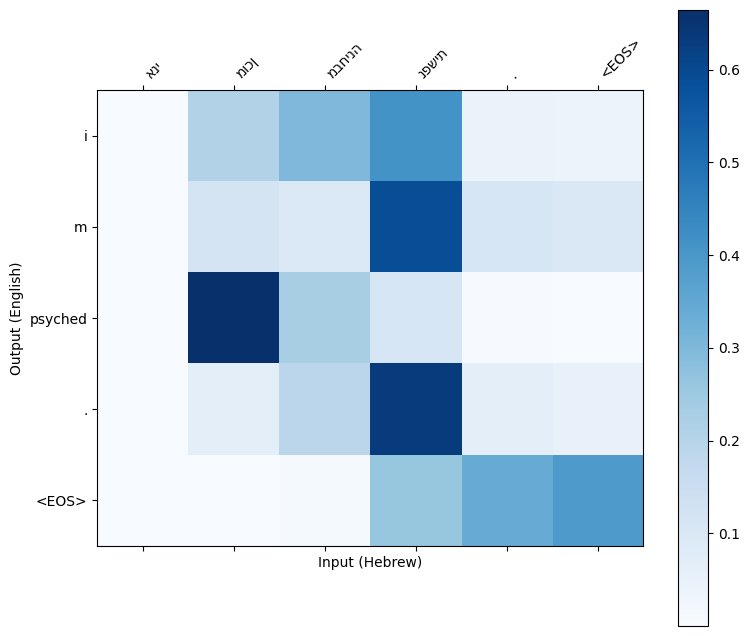

input = אני מאד מצטער .
output = i m very sorry for being late . <EOS>


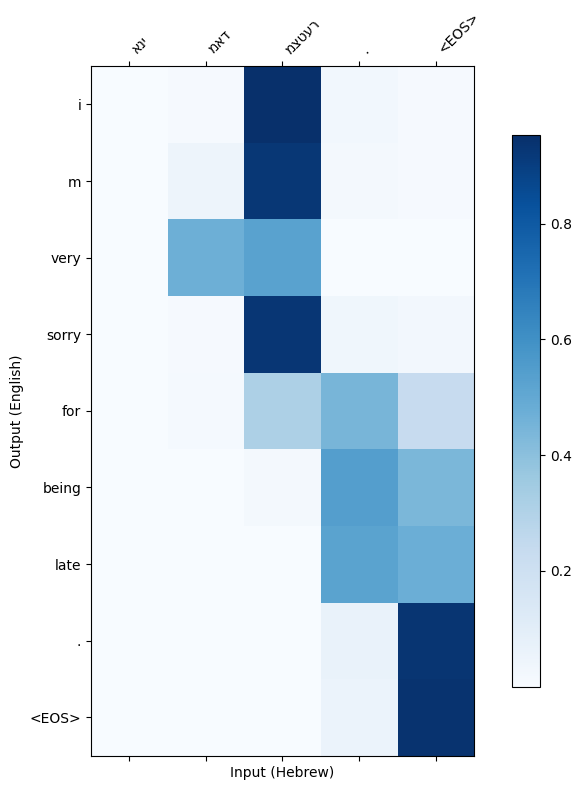

input = אני קטן למדי .
output = i m pretty short tempered . <EOS>


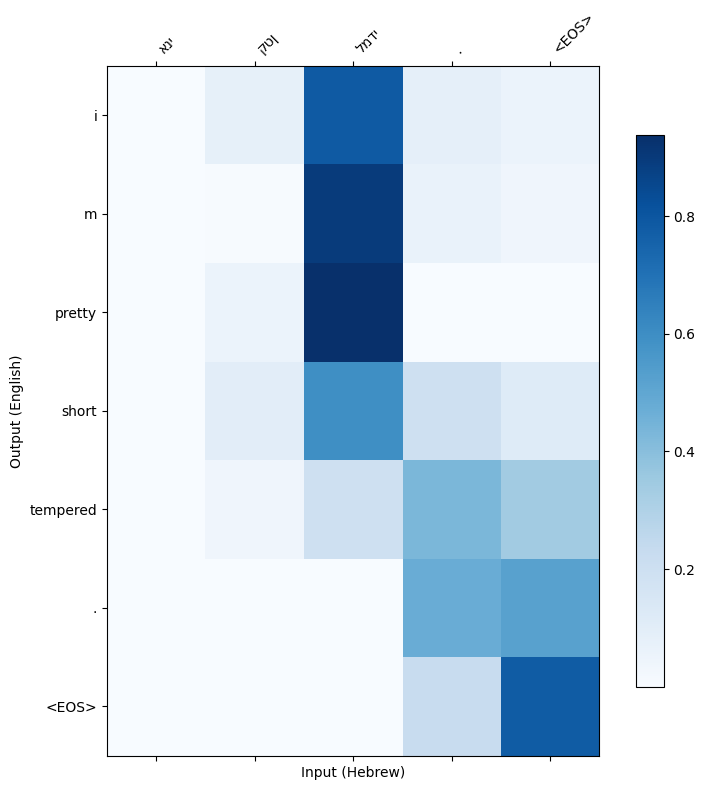

input = אני בסדר .
output = i am okay . <EOS>


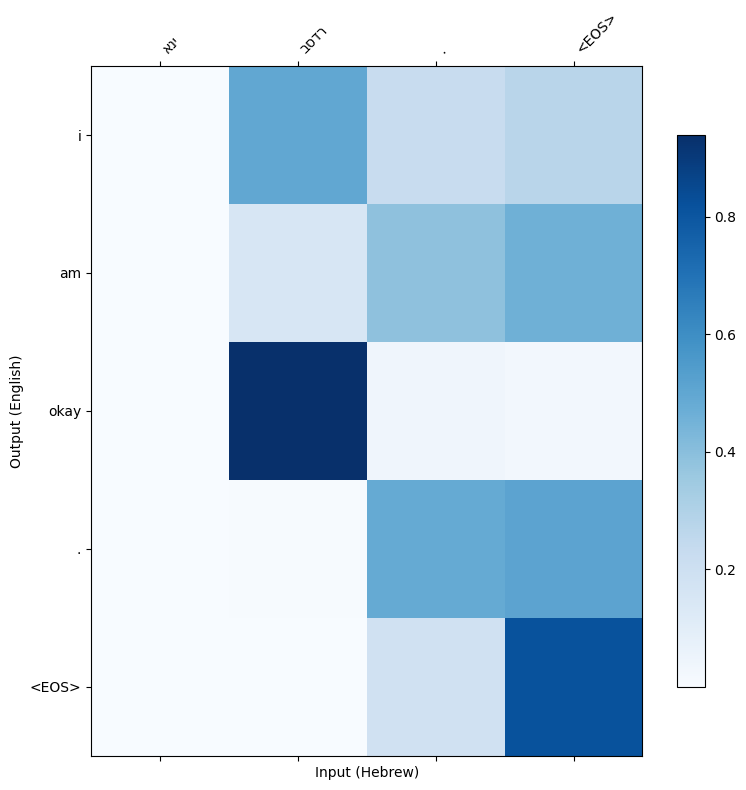

input = אנו אוכלים בשר קר לארוחת ערב .
output = we re having cold cuts for supper . <EOS>


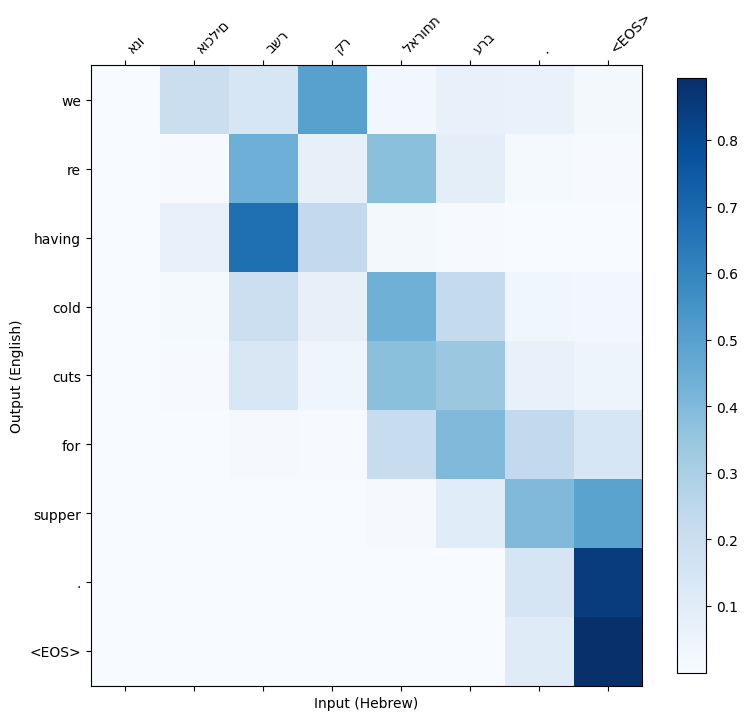

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def showAttention(input_sentence, output_words, attentions):
    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(attentions.cpu().numpy(), cmap='Blues')
    fig.colorbar(cax, ax=ax, shrink=0.8)

    input_words = input_sentence.split(' ') + ['<EOS>']
    ax.set_xticks(range(len(input_words)))
    ax.set_yticks(range(len(output_words)))
    ax.set_xticklabels(input_words, rotation=45, ha='left', fontsize=10)
    ax.set_yticklabels(output_words, fontsize=10)

    ax.set_xlabel('Input (Hebrew)')
    ax.set_ylabel('Output (English)')

    plt.tight_layout()
    plt.show()

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

# show attention for 5 random sentences
print("Attention plots for 5 random sentences:")
for i in range(5):
    pair = random.choice(pairs)
    evaluateAndShowAttention(pair[0])


>the attention plots show that the model learns which hebrew words to focus on when generating each english word. you can see stronger attention (darker blue) on relevant words.
for example in "i am okay" the word "okay" strongly attends to "בסדר" which is the hebrew word for okay.
in the longer sentence about cold cuts you can see a rough diagonal pattern showing the word alignment.
some translations are not perfect though "אני קטן למדי" means "i m pretty small" but the model output "i m pretty short tempered" which is wrong. same with "אני מאד מצטער" (i m very sorry)
became "i m very sorry for being late" adding extra words that werent there.

# Q2.3

**Do you think this model performs well?**

The model does okay but not perfect. In the 20 random sentences evaluation most translations were correct or close. But in the attention plots we saw some mistakes like "אני קטן למדי" (i m pretty small) became "i m pretty short tempered" and "אני מאד מצטער" (i m very sorry) became "i m very sorry for being late" with extra words added.

The attention mechanism seems to work though. You can see in the plots that the model focuses on the right hebrew words when generating english. Like "okay" attending to "בסדר".

**What are its limitations?**

The main limitation is the filtered dataset. We only used sentences starting with "i am", "he is" etc so the model only learned a small part of the language. MAX_LENGTH of 10 is also short.

Another problem is the model sometimes adds words that arent in the original or translates to a completely different sentence with similar structure. I think this is because many training sentences have similar patterns so it gets confused.

**What would you do to improve it?**

I would try using a bidirectional encoder so it can see context from both directions. Could also train on more data without the eng_prefixes filter. Using pretrained embeddings might help with rare words. And maybe increase hidden size or add more layers.

# Q2.4

In [14]:
improved_hidden_size = 256

class ImprovedEncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(ImprovedEncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        # bidirectional GRU with 2 layers
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=2,
                         batch_first=True, bidirectional=True, dropout=dropout_p)
        self.dropout = nn.Dropout(dropout_p)
        # project bidirectional output back to hidden_size
        self.fc = nn.Linear(hidden_size * 2, hidden_size)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        # combine bidirectional outputs
        output = self.fc(output)
        # combine the two directions of the last layer for decoder init
        hidden = hidden.view(2, 2, -1, self.hidden_size)
        hidden = torch.cat([hidden[:, 0, :, :], hidden[:, 1, :, :]], dim=-1)
        hidden = self.fc(hidden)
        hidden = hidden[-1:, :, :]
        return output, hidden

class ImprovedAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(ImprovedAttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, num_layers=2,
                        batch_first=True, dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden.repeat(2, 1, 1)
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)
        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))
        query = hidden[-1:].permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)
        return output, hidden, attn_weights

improved_encoder = ImprovedEncoderRNN(input_lang.n_words, improved_hidden_size).to(device)
improved_decoder = ImprovedAttnDecoderRNN(improved_hidden_size, output_lang.n_words).to(device)

print("Training improved model...")
train(train_dataloader, improved_encoder, improved_decoder, epochs, print_every=5)

improved_encoder.eval()
improved_decoder.eval()
print("\nEvaluating improved model on 20 random sentences:")
for i in range(20):
    pair = random.choice(pairs)
    print('>', pair[0])
    print('=', pair[1])
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, pair[0])
        encoder_outputs, encoder_hidden = improved_encoder(input_tensor)
        decoder_outputs, _, _ = improved_decoder(encoder_outputs, encoder_hidden)
        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()
        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    print('<', ' '.join(decoded_words))
    print('')

Training improved model...
0m 44s (- 6m 43s) (5 10%) 1.4059
1m 30s (- 6m 3s) (10 20%) 0.3553
2m 15s (- 5m 16s) (15 30%) 0.0994
2m 59s (- 4m 28s) (20 40%) 0.0694
3m 43s (- 3m 43s) (25 50%) 0.0616
4m 27s (- 2m 58s) (30 60%) 0.0576
5m 10s (- 2m 13s) (35 70%) 0.0559
5m 54s (- 1m 28s) (40 80%) 0.0505
6m 37s (- 0m 44s) (45 90%) 0.0500
7m 21s (- 0m 0s) (50 100%) 0.0495

Evaluating improved model on 20 random sentences:
> אני אוהד גולף מושבע .
= i m a big fan of golf .
< i m a big fan of golf . <EOS>

> אינני פאשיסט .
= i m not a fascist .
< i m not a fascist . <EOS>

> אני זז .
= i m moving .
< i m moving . <EOS>

> אני רודף שלום .
= i m a pacifist .
< i m a pacifist . <EOS>

> אנו מחפשים מקום לינה .
= we re looking for a place to sleep .
< we re looking for a place to sleep . <EOS>

> אני עצלנית מדי להכין את שיעורי הבית שלי .
= i m too lazy to do my homework .
< i m too lazy to do my homework . <EOS>

> אני עוזב את העיר לכמה ימים .
= i m leaving town for a few days .
< i m leaving town for a


Attention plots for improved model (5 random sentences):
input = אני לא בטוח .
output = i m not confident . <EOS>


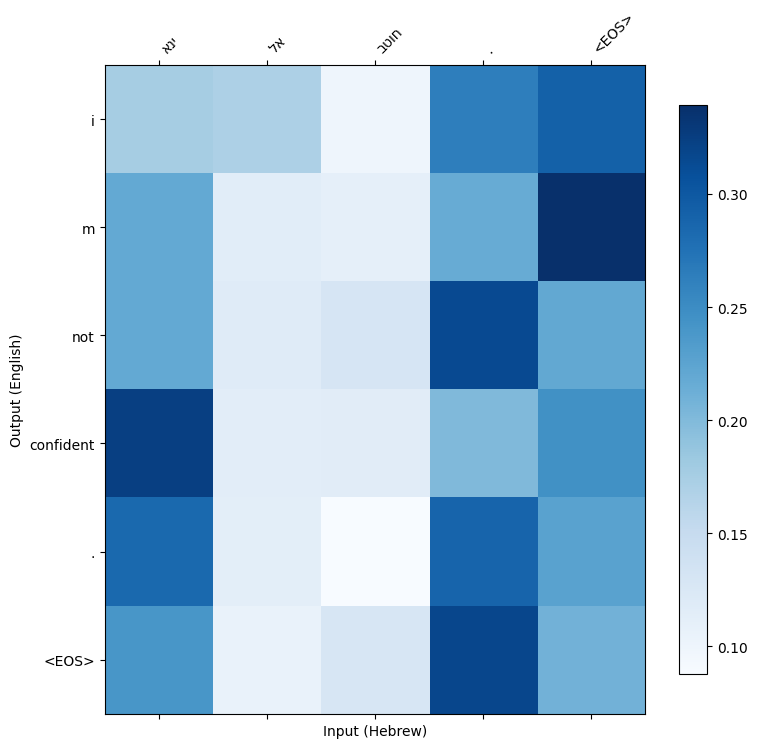

input = הוא מורעל על כדורגל .
output = he s getting into soccer . <EOS>


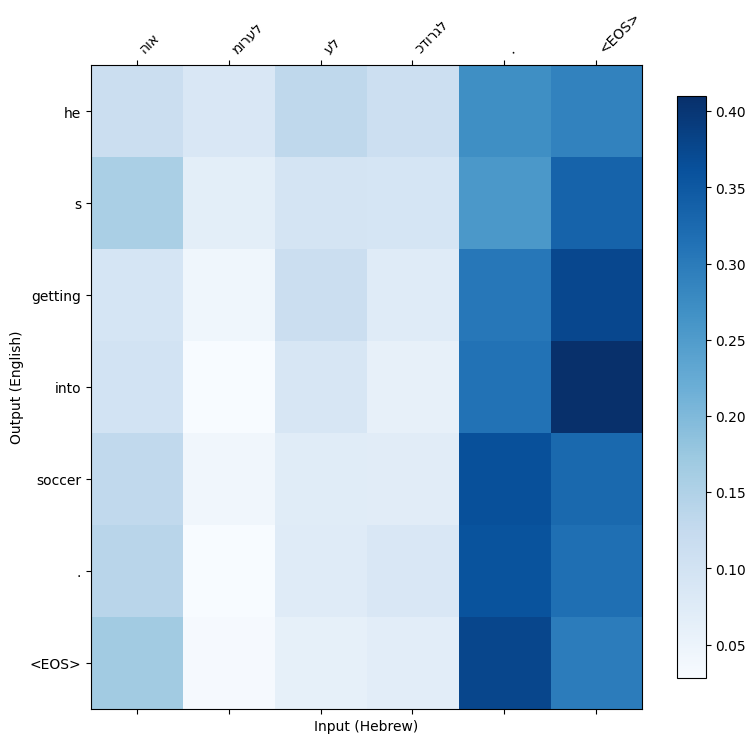

input = אנו בוגרים .
output = we re mature . <EOS>


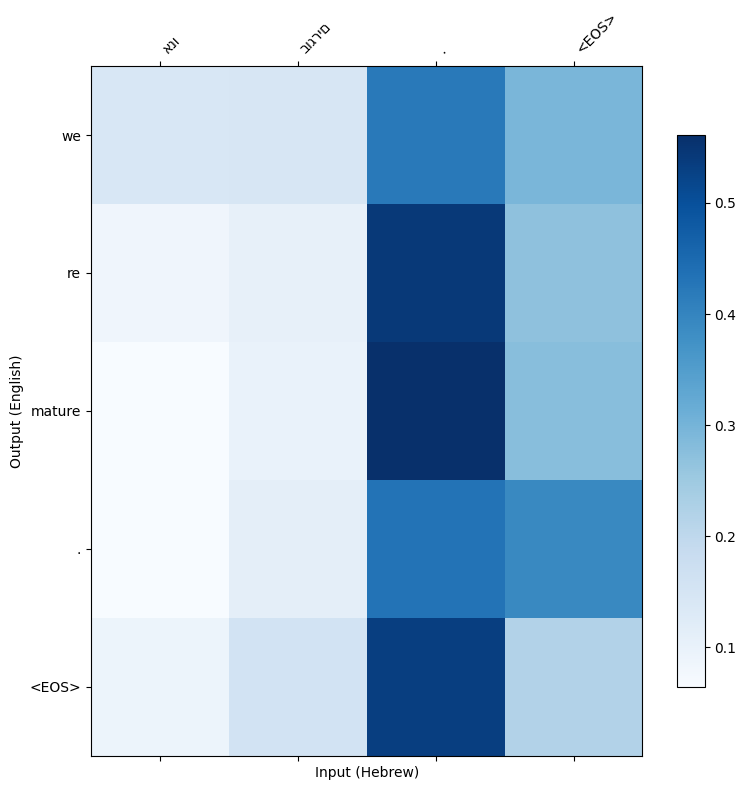

input = יש לי עניין בשחייה .
output = i am interested in swimming . <EOS>


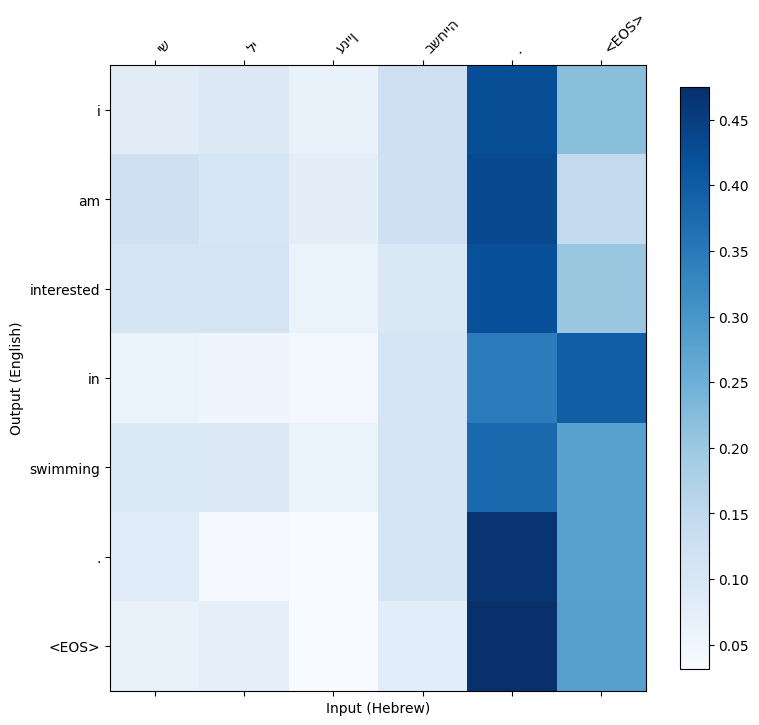

input = אני מצטער .
output = i m sorry . <EOS>


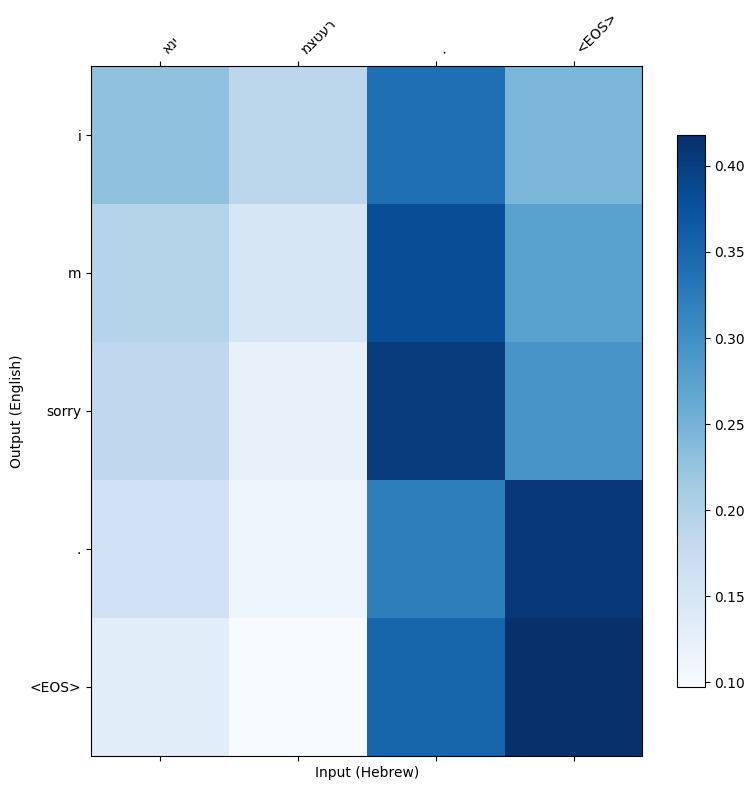

In [15]:
def evaluateImproved(sentence):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        encoder_outputs, encoder_hidden = improved_encoder(input_tensor)
        decoder_outputs, _, decoder_attn = improved_decoder(encoder_outputs, encoder_hidden)
        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()
        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

print("\nAttention plots for improved model (5 random sentences):")
for i in range(5):
    pair = random.choice(pairs)
    output_words, attentions = evaluateImproved(pair[0])
    print('input =', pair[0])
    print('output =', ' '.join(output_words))
    showAttention(pair[0], output_words, attentions[0, :len(output_words), :])

# Results Comparison

The improved model with bidirectional encoder and 2 layers shows some improvements over the basic model.

The basic model had issues like translating "אני קטן למדי" (i m pretty small) to "i m pretty short tempered" which is completely wrong. The improved model makes smaller mistakes like repeating a word or adding an extra word at the end, but it doesnt completely change the meaning of the sentence.

Looking at the attention plots, the improved model shows cleaner attention patterns. The attention is more focused on specific words rather than spread out everywhere. For example "sorry" attends strongly to "מצטער" and "mature" attends to "בוגרים". The basic model had more diffuse attention.

I think the bidirectional encoder helps because it can see the whole hebrew sentence from both directions before encoding. This gives better context. The extra layer and bigger hidden size (256 vs 128) also helps the model learn more complex patterns.

The loss went down to 0.0495 which is lower than the basic model, showing better training convergence.